# CANSSI NCSC Ferry Delays
The objective of the national case study is about predicting ferry delays in BC Ferry sailings around Vancouver harbours in the test dataset.

In [1]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import time
from matplotlib.dates import DateFormatter
from matplotlib import dates
import warnings
warnings.filterwarnings('ignore')

## Graphical parameter setting

In [ ]:
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')

## Functions

In [2]:
## x axis and y axis offset
def adjust_spines(ax,spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward',15)) # outward by 10 points
            spine.set_smart_bounds(True)
        else:
            spine.set_color('none') 

In [4]:
## load data
train = pd.read_csv("train.csv")
vancouver = pd.read_csv("vancouver.csv")
victoria = pd.read_csv("victoria.csv")
traffic = pd.read_csv("traffic.csv")
test = pd.read_csv("test.csv")

In [5]:
traffic.isnull().sum()

Year                 0
Month                0
Day                  0
Hour               426
Minute              50
Second             476
Traffic.Ordinal      0
dtype: int64

In [6]:
vancouver.isnull().sum()

Date.Time                               0
Year                                    0
Month                                   0
Day                                     0
Time                                    0
Temperature.in.Celsius                 12
Dew.Point.Temperature.in.Celsius       12
Relative Humidity.in.Percent           12
Humidex.in.Celsius                  13910
Hour                                    0
dtype: int64

In [7]:
victoria.isnull().sum()

Date.Time                               0
Year                                    0
Month                                   0
Day                                     0
Time                                    0
Temperature.in.Celsius               4872
Dew.Point.Temperature.in.Celsius     4872
Relative.Humidity.in.Percent         4872
Wind.Direction.in.Degrees            4898
Wind.Speed.km.per.h                  4874
Visibility.in.km                     4872
Station.Pressure.in.kPa              4882
Weather                             10589
Hour                                    0
dtype: int64

In [8]:
traffic.isnull().sum()

Year                 0
Month                0
Day                  0
Hour               426
Minute              50
Second             476
Traffic.Ordinal      0
dtype: int64

In [671]:
# check the balance of the outcome
train["Delay.Indicator"].value_counts()

0    40516
1     8988
Name: Delay.Indicator, dtype: int64

## Data Cleaning

### Data cleaning for train

In [672]:
# Reformat time 
## train
train["Scheduled.Departure"] = pd.to_datetime(train["Scheduled.Departure"])
train["Scheduled.Departure"] = train["Scheduled.Departure"].apply(lambda x: x.strftime("%H:%M"))

## vancouver
vancouver["Date.Time"] = pd.to_datetime(vancouver["Date.Time"])
vancouver["Date.Time_hrm"] = vancouver["Date.Time"].apply(lambda x: x.strftime("%H:%M"))

## victoria
victoria["Date.Time"] = pd.to_datetime(victoria["Date.Time"])
victoria["Date.Time_hrm"] = victoria["Date.Time"].apply(lambda x: x.strftime("%H:%M"))

In [673]:
## mean of Delay Indicator classified by Trip Duration
train.loc[:,["Trip.Duration","Delay.Indicator"]].dropna().groupby(["Trip.Duration"]).mean()

,Delay.Indicator
Trip.Duration,
20.0,0.224443
35.0,0.035546
40.0,0.269248
95.0,0.165130
100.0,0.217239
120.0,0.114958


In [674]:
# Since Trip duration has very few categories, we decided to consider it as a categorical variable.
## delay rate grouped by Trip duration
train.loc[:,["Trip.Duration","Delay.Indicator"]].groupby("Trip.Duration").mean()

contingency1 = pd.crosstab(train['Trip.Duration'], train['Vessel.Name'])
contingency2 = pd.crosstab(train['Trip.Duration'], train['Trip'])

## chi square test for testing the correlations between Trip.Duration and (Vessel.Name,Trip)
c, p1, dof, expected = chi2_contingency(contingency1)
c, p2, dof, expected = chi2_contingency(contingency2)
print("The p-value of the chi-square test between Trip duration and Vessel.Name is {}".format(p1))
print("The p-value of the chi-square test between Trip duration and Trip is {}".format(p2))
print("Since Trip duration is highly dependent on Vessel.Name and Trip and Trip duration has missingness, we decided to delete Trip duration")

The p-value of the chi-square test between Trip duration and Vessel.Name is 0.0
The p-value of the chi-square test between Trip duration and Trip is 0.0
Since Trip duration is highly dependent on Vessel.Name and Trip and Trip duration has missingness, we decided to delete Trip duration


In [675]:
## Drop the level
train.drop(["Trip.Duration"],axis=1,inplace =True)

### Data cleaning for vancouver

In [676]:
vancouver.isna().sum()

Date.Time                               0
Year                                    0
Month                                   0
Day                                     0
Time                                    0
Temperature.in.Celsius                 12
Dew.Point.Temperature.in.Celsius       12
Relative Humidity.in.Percent           12
Humidex.in.Celsius                  13910
Hour                                    0
Date.Time_hrm                           0
dtype: int64

In [677]:
vancouver["time_index"] = pd.to_datetime(vancouver[['Year', 'Month','Day']])

## set two indeces
vancouver_two = vancouver.set_index([vancouver.index,"Date.Time"])

## by date
vancouver_1 = vancouver.set_index("Date.Time")

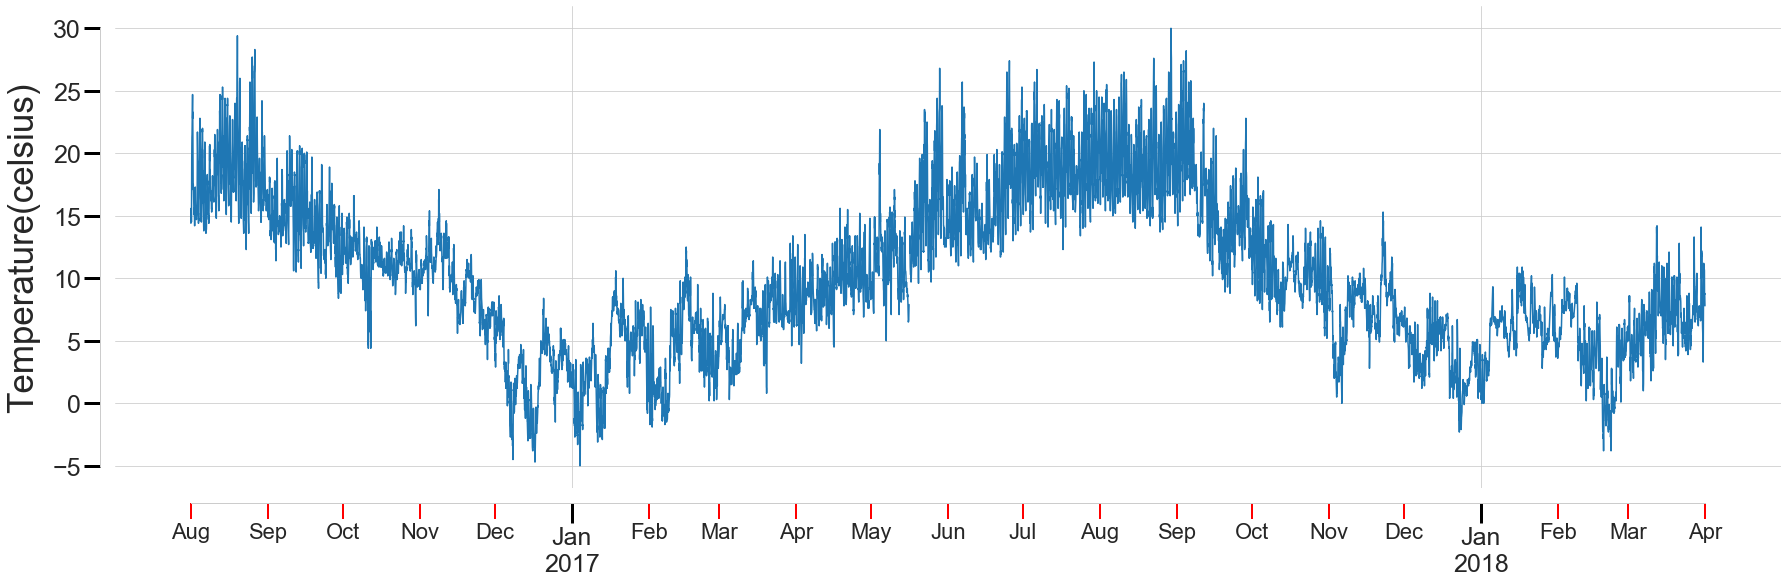

In [678]:
## Rename columns
fig, ax = plt.subplots(1,1,figsize=(25,8))

vancouver_1.rename(columns ={'Temperature.in.Celsius':"Temperature","Dew.Point.Temperature.in.Celsius":"Dew.Point","Relative Humidity.in.Percent":"Relative.Humidity","Humidex.in.Celsius":"Humidex"},inplace = True)
vancouver.rename(columns ={'Temperature.in.Celsius':"Temperature","Dew.Point.Temperature.in.Celsius":"Dew.Point","Relative Humidity.in.Percent":"Relative.Humidity","Humidex.in.Celsius":"Humidex"},inplace = True)


ax.plot(vancouver_1.index,vancouver_1["Temperature"])
## minor axis
ax.xaxis.set_minor_locator(dates.MonthLocator())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%b'))
ax.tick_params(direction = 'out', which='minor', length=16,width=2, color='r',labelsize = 22)


## major axis
ax.xaxis.set_major_locator(dates.YearLocator(1,month=1,day=1))
ax.xaxis.set_major_formatter(dates.DateFormatter('%b\n%Y'))
ax.xaxis.label.set_visible(False)
ax.tick_params(axis= "x",direction = 'out',which='major', length=20,width=3, color='k',labelsize = 25)
ax.tick_params(axis= "y",direction = 'out',which='major', length=16,width=3, color='k',labelsize = 25)


ax.set_ylabel("Temperature(celsius)",size = 35,labelpad=12)
plt.tight_layout()

adjust_spines(ax, ['left', 'bottom'])

In [679]:
# index missing values of Temperature as 1
## index of missing values in Temperature
index = vancouver.loc[vancouver["Temperature"].isna()].index
## encode non-missing values as 0
vancouver.loc[~vancouver.index.isin(index),"impute_encoder_van"] =0
## encode missing values as 1
vancouver.loc[index,"impute_encoder_van"] =1

vancouver_1["impute_encoder_van"] = vancouver["impute_encoder_van"].to_numpy()

In [680]:
## impute the values with the average of the 3 backward and forward neighbouring days' values (by vancouver)
for ind in index:
    inds = [ind +i*24 for i in [-3,-2,-1,1,2,3]]
    vancouver.loc[ind,"Temperature"] = vancouver.loc[inds,"Temperature"].mean()
    vancouver.loc[ind,"Dew.Point"] = vancouver.loc[inds,"Dew.Point"].mean()
    vancouver.loc[ind,"Relative.Humidity"] = vancouver.loc[inds,"Relative.Humidity"].mean()
    
## impute the values with the aver age of the 3 backward and forward neighbouring days' values (by vancouver_1)
for ind in index:
    inds = [ind +i*24 for i in [-3,-2,-1,1,2,3]]
    vancouver_1.iloc[ind,5] = vancouver_1.iloc[inds,5].mean()  # Temperature
    vancouver_1.iloc[ind,6] = vancouver_1.iloc[inds,6].mean()  # Dew.Point
    vancouver_1.iloc[ind,7] = vancouver_1.iloc[inds,7].mean()  # Relative.Humidity


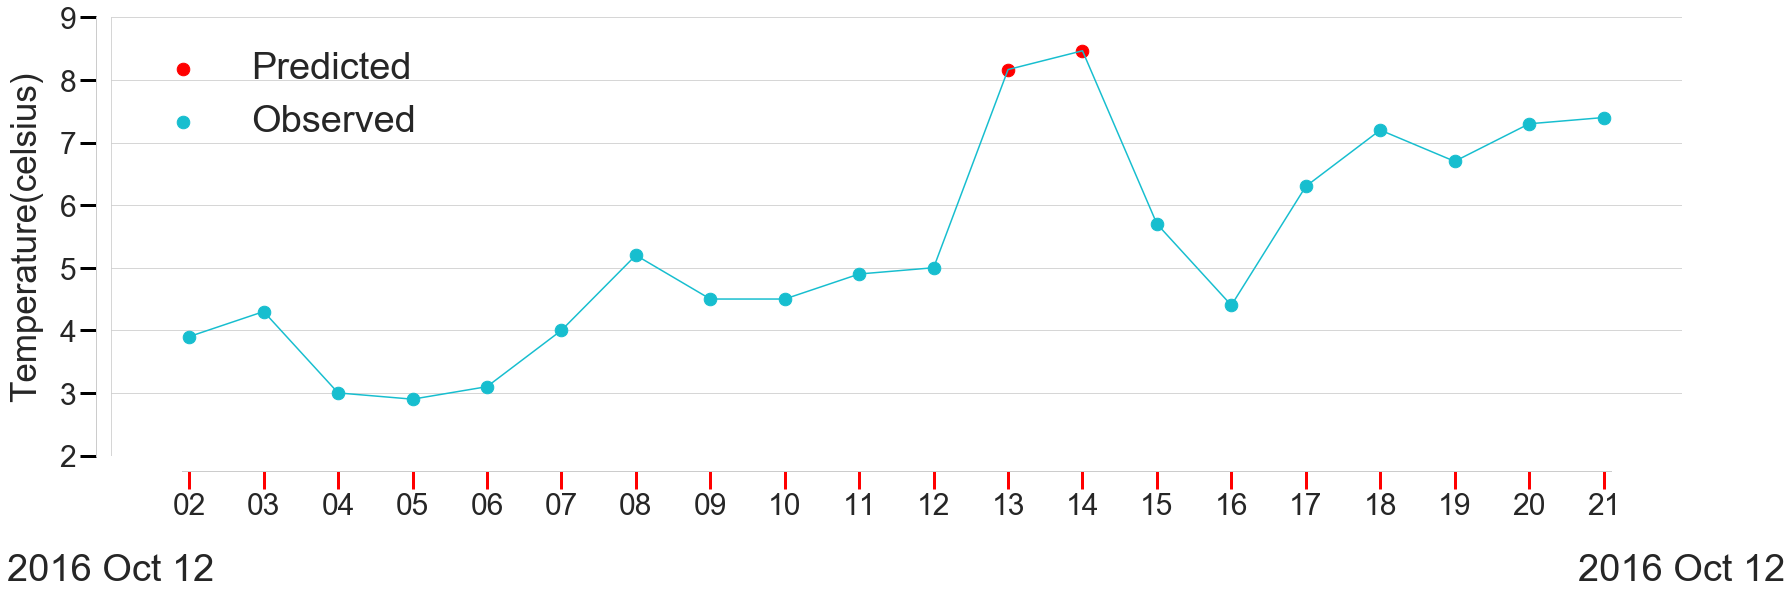

In [681]:
## Rename columns
fig, ax = plt.subplots(1,1,figsize=(25,8))


ax.plot(vancouver_1.iloc[1730:1750,5].index,vancouver_1.iloc[1730:1750,5],c='#17becf')


ax.scatter(vancouver_1.iloc[[1741,1742],:].index,vancouver_1.iloc[[1741,1742],5],c = "r",s = 158, marker = 'o',label = "Predicted")
ax.scatter(vancouver_1.iloc[[i for i in range(1730,1750) if i not in [1741,1742]],:].index,vancouver_1.iloc[[i for i in range(1730,1750) if i not in [1741,1742]],5],c = '#17becf',s = 158, marker = 'o',label = "Observed")

## minor xaxis
ax.xaxis.set_minor_locator(dates.HourLocator(byhour=range(2,22,1)))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%H'))
ax.xaxis.label.set_visible(False)
ax.tick_params(axis= "x",direction = 'out',which='minor', length=18,width=3, color='r',labelsize = 30)#


## major xaxis
ax.xaxis.set_major_locator(dates.DayLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n%Y %b %d'))
ax.xaxis.label.set_visible(False)
ax.tick_params(axis= "x",direction = 'out',which='major', length=0,width=3, color='k',labelsize =38)#
ax.tick_params(axis= "y",direction = 'out',which='major', length=16,width=3, color='k',labelsize = 30)


ax.set_ylabel("Temperature(celsius)",size = 35,labelpad=16)
plt.tight_layout()
ax.set_yticks([i for i in range(2,10)])
ax.legend(loc="best",fontsize = 38)

adjust_spines(ax, ['left', 'bottom'])

In [682]:
## factorize impute_encoder_van
vancouver['impute_encoder_van'] = vancouver['impute_encoder_van'].astype('int')
vancouver['impute_encoder_van'] = vancouver['impute_encoder_van'].astype('category')

### Imputation for victoria

In [683]:
## Rename columns for victoria
victoria.rename(columns ={'Temperature.in.Celsius':"Temperature","Dew.Point.Temperature.in.Celsius":"Dew.Point","Relative.Humidity.in.Percent":"Relative.Humidity","Wind.Direction.in.Degrees":"Wind.Direction","Wind.Speed.km.per.h":"Wind.Speed","Visibility.in.km":"Visibility","Station.Pressure.in.kPa":"Station.Pressure"},inplace = True)

victoria["Date.Time"] = pd.to_datetime(victoria["Date.Time"])

In [684]:
np.unique(victoria.loc[victoria["Temperature"].isna()].Time)

array(['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00',
       '09:00', '10:00', '14:00', '17:00', '20:00', '21:00', '22:00',
       '23:00'], dtype=object)

In [685]:
victoria

,Date.Time,Year,Month,Day,Time,Temperature,Dew.Point,Relative.Humidity,Wind.Direction,Wind.Speed,Visibility,Station.Pressure,Weather,Hour,Date.Time_hrm
0,2016-08-01 00:00:00,2016,8,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,00:00
1,2016-08-01 01:00:00,2016,8,1,01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,01:00
2,2016-08-01 02:00:00,2016,8,1,02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,02:00
3,2016-08-01 03:00:00,2016,8,1,03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,03:00
4,2016-08-01 04:00:00,2016,8,1,04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14587,2018-03-31 19:00:00,2018,3,31,19:00,9.1,5.7,80.0,240.0,12.0,24.1,101.97,Mostly Cloudy,19,19:00
14588,2018-03-31 20:00:00,2018,3,31,20:00,9.0,4.0,71.0,260.0,11.0,24.1,101.96,NaN,20,20:00
14589,2018-03-31 21:00:00,2018,3,31,21:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,21:00
14590,2018-03-31 22:00:00,2018,3,31,22:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,22:00


In [686]:
## multiple methods for imputation[Temperature]
victoria = victoria.assign(RollingMean_Tem = victoria.Temperature.fillna(victoria.Temperature.rolling(24,min_periods=1,).mean()))
victoria = victoria.assign(InterpolateLinear_Tem = victoria.Temperature.interpolate(method='linear'))
victoria = victoria.assign(InterpolateQuadratic_Tem = victoria.Temperature.interpolate(method='quadratic'))
victoria = victoria.assign(InterpolateCubic_Tem = victoria.Temperature.interpolate(method='cubic'))
victoria = victoria.assign(InterpolateSpline3_Tem = victoria.Temperature.interpolate(method='spline', order=3))

In [687]:
## encode missing values
index_miss  = victoria.loc[victoria["Temperature"].isna()].index
victoria.loc[~victoria.index.isin(index_miss),"impute_encoder_vic"] =0
victoria.loc[index_miss,"impute_encoder_vic"] =1

## factorize imputation indicator
victoria.impute_encoder_vic = victoria.impute_encoder_vic.astype("int64")
victoria.impute_encoder_vic = victoria.impute_encoder_vic.astype("category")

## set date index
victoria_1 = victoria.set_index("Date.Time")

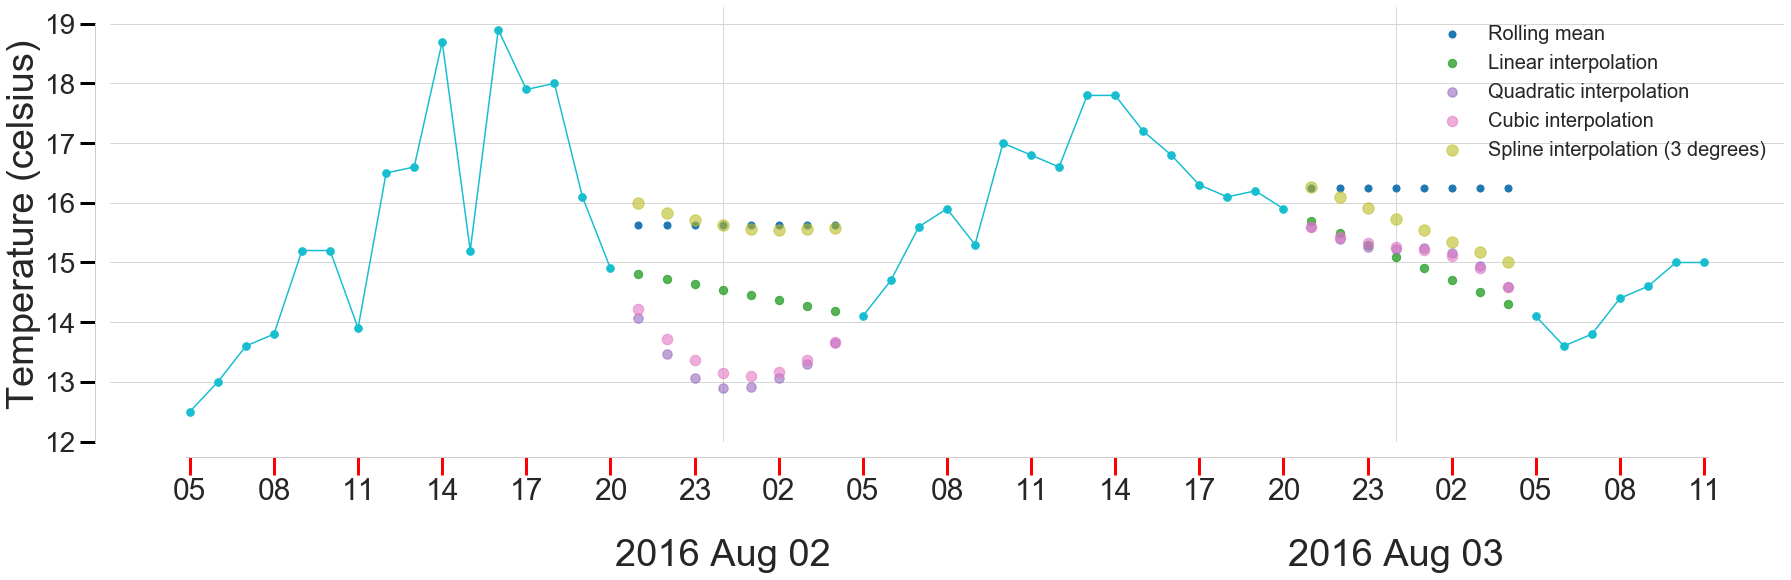

In [688]:
fig, ax = plt.subplots(1,1,figsize=(30,8))

## Visualization of temperature imputation
index_1 = index_miss[index_miss<=60]

colors = [plt.cm.tab10(i/float(5)) for i in range(5)]

ax.plot(victoria_1.iloc[0:60,:].index,victoria_1.iloc[0:60,4],c='#17becf')

ax.scatter(victoria_1.iloc[0:60,:].index,victoria_1.iloc[0:60,4],c = '#17becf', marker = 'o',s=58)

## Rolling mean
ax.scatter(victoria_1.iloc[index_1,:].index,victoria_1.iloc[index_1,14],color = colors[0], marker = 'o',s=50,label = "Rolling mean")

## InterpolateLinear_Tem
ax.scatter(victoria_1.iloc[index_1,:].index,victoria_1.iloc[index_1,15],color = colors[1], marker = 'o',s=70,alpha=0.8,label = "Linear interpolation")

## InterpolateQuadratic
ax.scatter(victoria_1.iloc[index_1,:].index,victoria_1.iloc[index_1,16],color = colors[2], marker = 'o',s=90,alpha=0.6,label = "Quadratic interpolation")

## InterpolateCubic
ax.scatter(victoria_1.iloc[index_1,:].index,victoria_1.iloc[index_1,17],color = colors[3], marker = 'o',s=110,alpha=0.6, label = "Cubic interpolation")

## InterpolateSpline3
ax.scatter(victoria_1.iloc[index_1,:].index,victoria_1.iloc[index_1,18],color = colors[4], marker = 'o',s=130,alpha=0.6,label = "Spline interpolation (3 degrees)")


## minor xaxis
ax.xaxis.set_minor_locator(dates.HourLocator(interval = 3))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%H'))
ax.tick_params(axis= "x",direction = 'out',which='minor', length=18,width=3, color='r',labelsize = 30)


## major xaxis
ax.xaxis.set_major_locator(dates.DayLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n%Y %b %d'))
ax.xaxis.label.set_visible(False)
ax.tick_params(axis= "x",direction = 'out',which='major', length=0,width=3, color='k',labelsize =38)

ax.tick_params(axis= "y",direction = 'out',which='major', length=15,width=3, color='k',labelsize = 28)


ax.set_ylabel("Temperature (celsius)",fontsize = 38)
ax.legend(loc = "best",fontsize = 20)
ax.set_yticks([i for i in range(12,20)])
adjust_spines(ax, ['left', 'bottom'])


## Visually, We finally decided to impute the missing values with quadratic imputation

In [689]:
## store victoria in victoria_1
victoria_dew = victoria.copy()

## Drop columns of unselected interpolation 
victoria_dew.drop(["InterpolateSpline3_Tem","RollingMean_Tem","InterpolateLinear_Tem","InterpolateCubic_Tem"],axis=1,inplace=True)

In [690]:
## Multiple interpolation methods
victoria_dew = victoria_dew.assign(RollingMean_Dew=victoria_dew["Dew.Point"].fillna(victoria_dew["Dew.Point"].rolling(24,min_periods=1,).mean()))
victoria_dew = victoria_dew.assign(InterpolateLinear_Dew=victoria_dew["Dew.Point"].interpolate(method='linear'))
victoria_dew = victoria_dew.assign(InterpolateQuadratic_Dew=victoria_dew["Dew.Point"].interpolate(method='quadratic'))
victoria_dew = victoria_dew.assign(InterpolateCubic_Dew=victoria_dew["Dew.Point"].interpolate(method='cubic'))
victoria_dew = victoria_dew.assign(InterpolateSpline3_Dew=victoria_dew["Dew.Point"].interpolate(method='spline', order=3))

## set Date.Time index
victoria_dew_1 = victoria_dew.set_index("Date.Time")

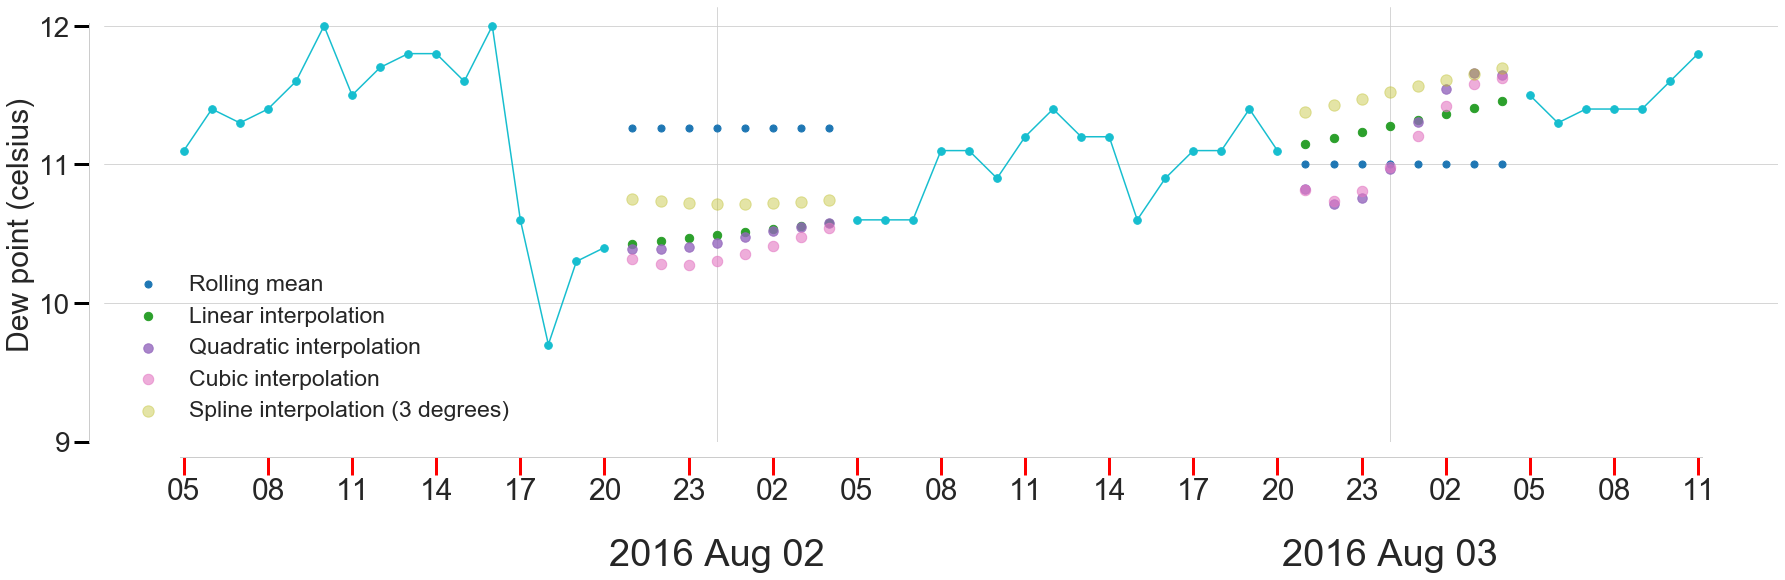

In [691]:
## Visualization of Dew.Point imputation
fig, ax = plt.subplots(1,1,figsize=(30,8))

index_1 = index_miss[index_miss<=60]

colors = [plt.cm.tab10(i/float(5)) for i in range(5)]

index_1 = index_miss[index_miss<=60]

colors = [plt.cm.tab10(i/float(5)) for i in range(5)]

ax.plot(victoria_dew_1.iloc[0:60,:].index,victoria_dew_1.iloc[0:60,5],c='#17becf')

ax.scatter(victoria_dew_1.iloc[0:60,:].index,victoria_dew_1.iloc[0:60,5],c = '#17becf', marker = 'o',s=58)

## Rolling mean
ax.scatter(victoria_dew_1.iloc[index_1,:].index,victoria_dew_1.iloc[index_1,16],color = colors[0], marker = 'o',s=50,label = "Rolling mean")

## InterpolateLinear_dew
ax.scatter(victoria_dew_1.iloc[index_1,:].index,victoria_dew_1.iloc[index_1,17],color = colors[1], marker = 'o',s=70,alpha=1,label = "Linear interpolation")

## InterpolateQuadratic
ax.scatter(victoria_dew_1.iloc[index_1,:].index,victoria_dew_1.iloc[index_1,18],color = colors[2], marker = 'o',s=90,alpha=0.8,label = "Quadratic interpolation")

## InterpolateCubic
ax.scatter(victoria_dew_1.iloc[index_1,:].index,victoria_dew_1.iloc[index_1,19],color = colors[3], marker = 'o',s=110,alpha=0.6, label = "Cubic interpolation")

## InterpolateSpline3
ax.scatter(victoria_dew_1.iloc[index_1,:].index,victoria_dew_1.iloc[index_1,20],color = colors[4], marker = 'o',s=130,alpha=0.4,label = "Spline interpolation (3 degrees)")

## minor xaxis
ax.xaxis.set_minor_locator(dates.HourLocator(interval = 3))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%H'))
ax.tick_params(axis= "x",direction = 'out',which='minor', length=18,width=3, color='r',labelsize = 30)

## major xaxis
ax.xaxis.set_major_locator(dates.DayLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n%Y %b %d'))
ax.xaxis.label.set_visible(False)
ax.tick_params(axis= "x",direction = 'out',which='major', length=0,width=3, color='k',labelsize =38)

ax.tick_params(axis= "y",direction = 'out',which='major', length=15,width=3, color='k',labelsize = 28)

ax.set_ylabel("Dew point (celsius)",fontsize = 30)
ax.legend(loc = "best",fontsize = 23)
ax.set_yticks([i for i in range(9,13)])
adjust_spines(ax, ['left', 'bottom'])

## we finally decided to impute the missing values with cubic spline imputation

In [692]:
##n Drop columns of unselected interpolation methods
victoria_dew_1.drop(["InterpolateSpline3_Dew","RollingMean_Dew","InterpolateQuadratic_Dew","InterpolateLinear_Dew"],axis=1,inplace=True)

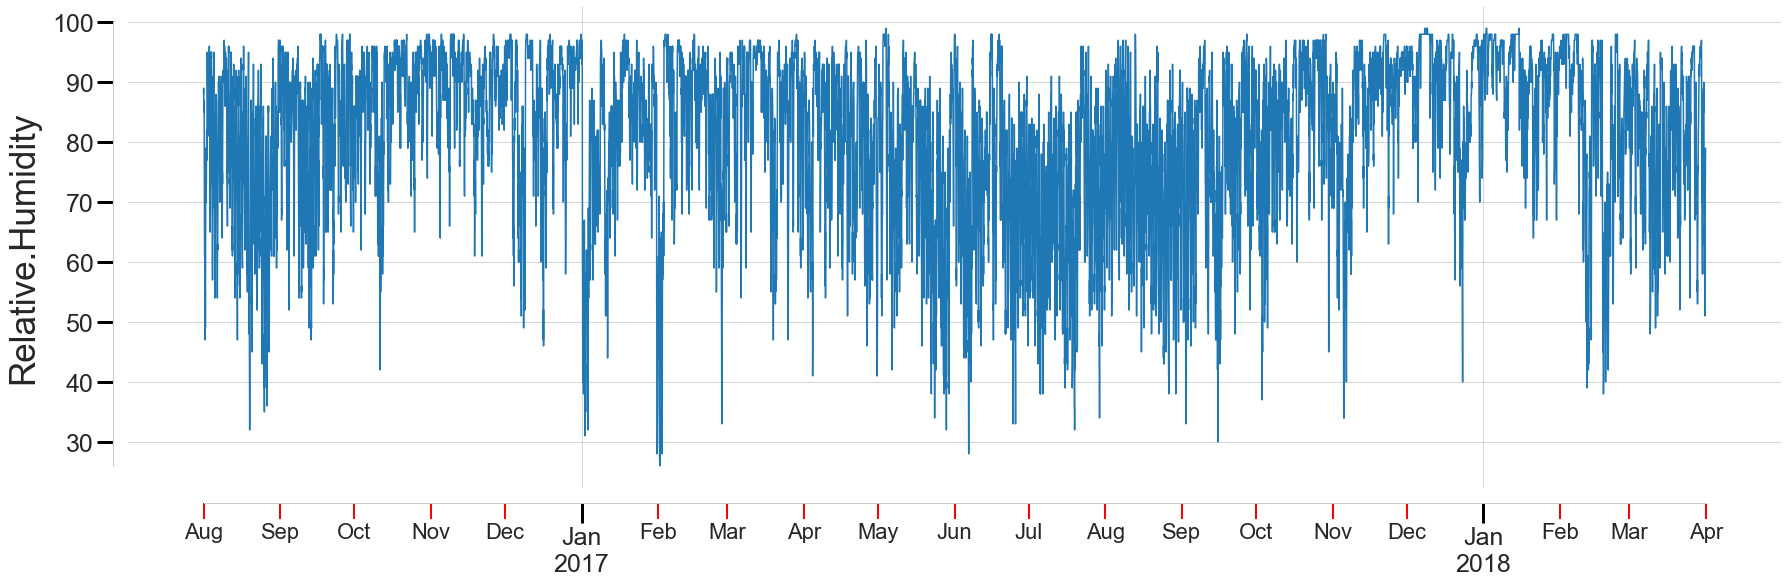

In [693]:
fig, ax = plt.subplots(1,1,figsize=(25,8))

ax.plot(victoria_dew_1.index,vancouver_1["Relative.Humidity"])
## minor axis
ax.xaxis.set_minor_locator(dates.MonthLocator())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%b'))
ax.tick_params(direction = 'out', which='minor', length=16,width=2, color='r',labelsize = 22)

## major axis
ax.xaxis.set_major_locator(dates.YearLocator(1,month=1,day=1))
ax.xaxis.set_major_formatter(dates.DateFormatter('%b\n%Y'))
ax.xaxis.label.set_visible(False)
ax.tick_params(axis= "x",direction = 'out',which='major', length=20,width=3, color='k',labelsize = 25)
ax.tick_params(axis= "y",direction = 'out',which='major', length=16,width=3, color='k',labelsize = 25)


ax.set_ylabel("Relative.Humidity",size = 35,labelpad=12)
plt.tight_layout()

adjust_spines(ax, ['left', 'bottom'])

In [694]:
victoria_dew_1 = victoria_dew_1.assign(RollingMean_Humi=victoria_dew_1["Relative.Humidity"].fillna(victoria_dew_1["Relative.Humidity"].rolling(24,min_periods=1,).mean()))
victoria_dew_1 = victoria_dew_1.assign(InterpolateLinear_Humi=victoria_dew_1["Relative.Humidity"].interpolate(method='linear'))
victoria_dew_1 = victoria_dew_1.assign(InterpolateQuadratic_Humi=victoria_dew_1["Relative.Humidity"].interpolate(method='quadratic'))
victoria_dew_1 = victoria_dew_1.assign(InterpolateCubic_Humi=victoria_dew_1["Relative.Humidity"].interpolate(method='cubic'))
victoria_dew_1 = victoria_dew_1.assign(InterpolateSpline3_Humi=victoria_dew_1["Relative.Humidity"].interpolate(method='spline', order=3))

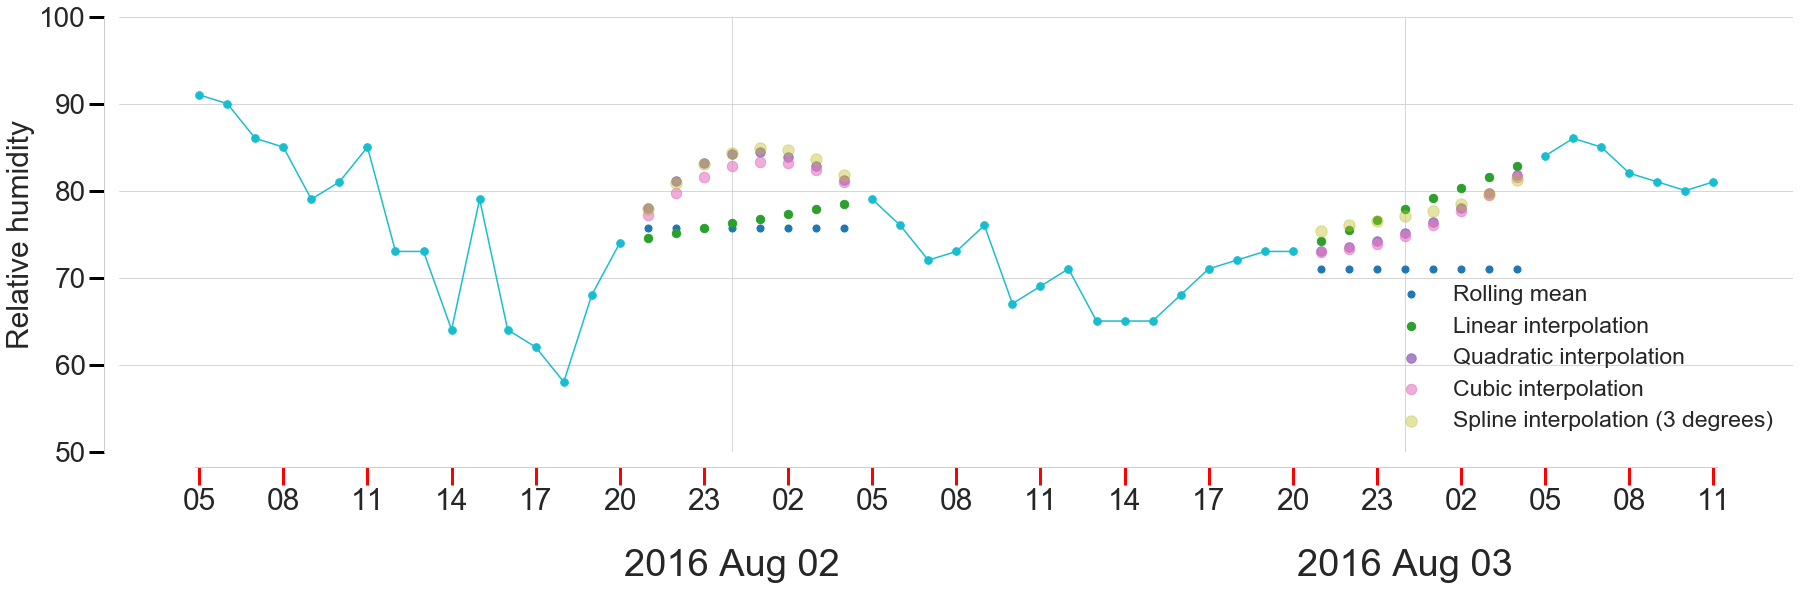

In [695]:
## Visualization of Dew.Point imputation
fig, ax = plt.subplots(1,1,figsize=(30,8))

index_1 = index_miss[index_miss<=60]

colors = [plt.cm.tab10(i/float(5)) for i in range(5)]

index_1 = index_miss[index_miss<=60]

colors = [plt.cm.tab10(i/float(5)) for i in range(5)]

ax.plot(victoria_dew_1.iloc[0:60,:].index,victoria_dew_1.iloc[0:60,6],c='#17becf')

ax.scatter(victoria_dew_1.iloc[0:60,:].index,victoria_dew_1.iloc[0:60,6],c = '#17becf', marker = 'o',s=58)

## Rolling mean
ax.scatter(victoria_dew_1.iloc[index_1,:].index,victoria_dew_1.iloc[index_1,17],color = colors[0], marker = 'o',s=50,label = "Rolling mean")

## InterpolateLinear_dew
ax.scatter(victoria_dew_1.iloc[index_1,:].index,victoria_dew_1.iloc[index_1,18],color = colors[1], marker = 'o',s=70,alpha=1,label = "Linear interpolation")

## InterpolateQuadratic
ax.scatter(victoria_dew_1.iloc[index_1,:].index,victoria_dew_1.iloc[index_1,19],color = colors[2], marker = 'o',s=90,alpha=0.8,label = "Quadratic interpolation")

## InterpolateCubic
ax.scatter(victoria_dew_1.iloc[index_1,:].index,victoria_dew_1.iloc[index_1,20],color = colors[3], marker = 'o',s=110,alpha=0.6, label = "Cubic interpolation")

## InterpolateSpline3
ax.scatter(victoria_dew_1.iloc[index_1,:].index,victoria_dew_1.iloc[index_1,21],color = colors[4], marker = 'o',s=130,alpha=0.4,label = "Spline interpolation (3 degrees)")

## minor xaxis
ax.xaxis.set_minor_locator(dates.HourLocator(interval = 3))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%H'))
ax.tick_params(axis= "x",direction = 'out',which='minor', length=18,width=3, color='r',labelsize = 30)

## major xaxis
ax.xaxis.set_major_locator(dates.DayLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n%Y %b %d'))
ax.xaxis.label.set_visible(False)
ax.tick_params(axis= "x",direction = 'out',which='major', length=0,width=3, color='k',labelsize =38)

ax.tick_params(axis= "y",direction = 'out',which='major', length=15,width=3, color='k',labelsize = 28)

ax.set_ylabel("Relative humidity",fontsize = 30)
ax.legend(loc = "best",fontsize = 23)
ax.set_yticks([i for i in range(50,101,10)])
adjust_spines(ax, ['left', 'bottom'])

## we finally decided to go with interpolation of cubic spline 

In [696]:
victoria_dew_1.drop(["InterpolateSpline3_Humi","RollingMean_Humi","InterpolateQuadratic_Humi","InterpolateLinear_Humi"],axis=1,inplace=True)
victoria_dew_1.drop(["Visibility","Weather"],axis=1,inplace = True)

In [697]:
victoria_dew_1 = victoria_dew_1.assign(RollingMean_Press=victoria_dew_1["Station.Pressure"].fillna(victoria_dew_1["Station.Pressure"].rolling(24,min_periods=1,).mean()))
victoria_dew_1 = victoria_dew_1.assign(InterpolateLinear_Press=victoria_dew_1["Station.Pressure"].interpolate(method='linear'))
victoria_dew_1 = victoria_dew_1.assign(InterpolateQuadratic_Press=victoria_dew_1["Station.Pressure"].interpolate(method='quadratic'))
victoria_dew_1 = victoria_dew_1.assign(InterpolateCubic_Press=victoria_dew_1["Station.Pressure"].interpolate(method='cubic'))
victoria_dew_1 = victoria_dew_1.assign(InterpolateSpline3_Press=victoria_dew_1["Station.Pressure"].interpolate(method='spline', order=3))

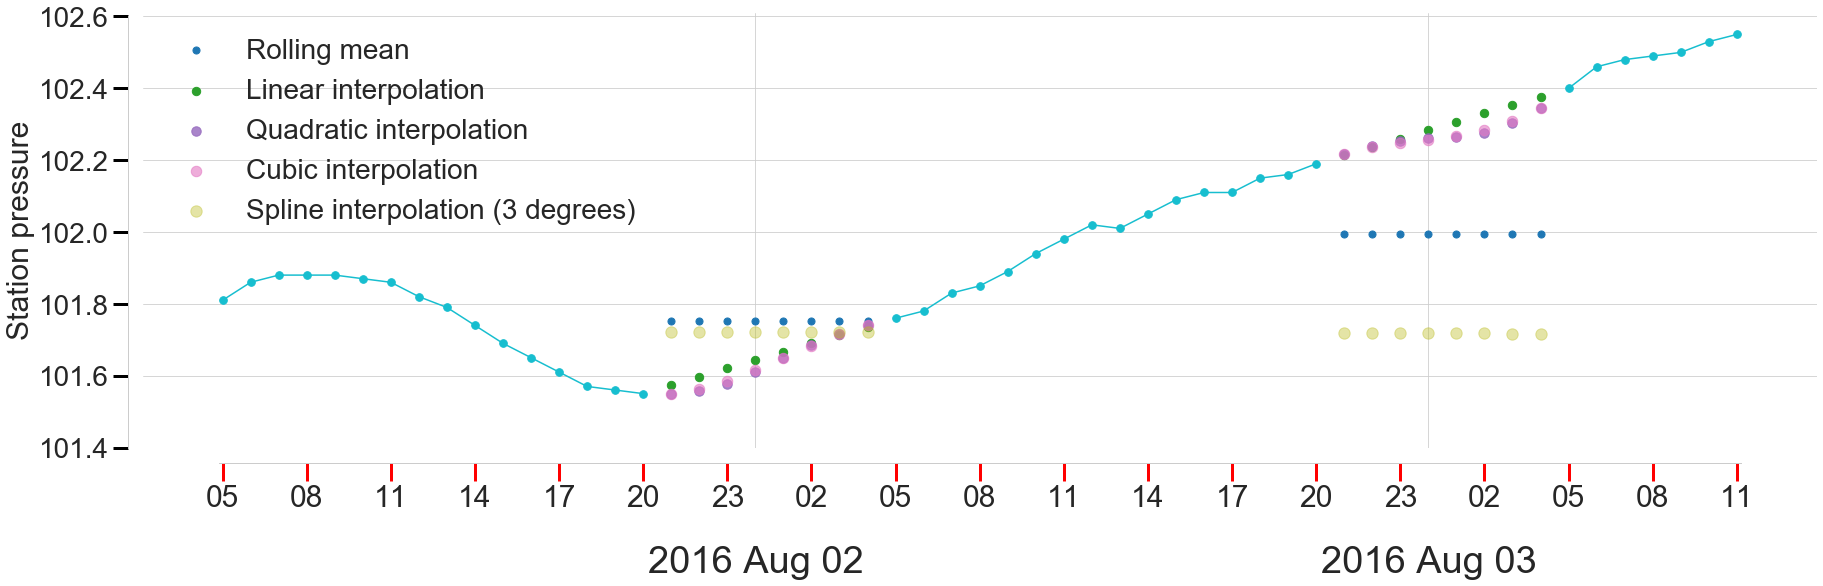

In [698]:
## Visualization of Station pressure imputation
fig, ax = plt.subplots(1,1,figsize=(30,8))

index_1 = index_miss[index_miss<=60]

colors = [plt.cm.tab10(i/float(5)) for i in range(5)]

colors = [plt.cm.tab10(i/float(5)) for i in range(5)]

ax.plot(victoria_dew_1.iloc[0:60,:].index,victoria_dew_1.iloc[0:60,9],c='#17becf')

ax.scatter(victoria_dew_1.iloc[0:60,:].index,victoria_dew_1.iloc[0:60,9],c = '#17becf', marker = 'o',s=58)

## Rolling mean
ax.scatter(victoria_dew_1.iloc[index_1,:].index,victoria_dew_1.iloc[index_1,16],color = colors[0], marker = 'o',s=50,label = "Rolling mean")

## InterpolateLinear_dew
ax.scatter(victoria_dew_1.iloc[index_1,:].index,victoria_dew_1.iloc[index_1,17],color = colors[1], marker = 'o',s=70,alpha=1,label = "Linear interpolation")

## InterpolateQuadratic
ax.scatter(victoria_dew_1.iloc[index_1,:].index,victoria_dew_1.iloc[index_1,18],color = colors[2], marker = 'o',s=90,alpha=0.8,label = "Quadratic interpolation")

## InterpolateCubic
ax.scatter(victoria_dew_1.iloc[index_1,:].index,victoria_dew_1.iloc[index_1,19],color = colors[3], marker = 'o',s=110,alpha=0.6, label = "Cubic interpolation")

## InterpolateSpline3
ax.scatter(victoria_dew_1.iloc[index_1,:].index,victoria_dew_1.iloc[index_1,20],color = colors[4], marker = 'o',s=130,alpha=0.4,label = "Spline interpolation (3 degrees)")

## minor xaxis
ax.xaxis.set_minor_locator(dates.HourLocator(interval = 3))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%H'))
ax.tick_params(axis= "x",direction = 'out',which='minor', length=18,width=3, color='r',labelsize = 30)

## major xaxis
ax.xaxis.set_major_locator(dates.DayLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n%Y %b %d'))
ax.xaxis.label.set_visible(False)
ax.tick_params(axis= "x",direction = 'out',which='major', length=0,width=3, color='k',labelsize =38)

ax.tick_params(axis= "y",direction = 'out',which='major', length=15,width=3, color='k',labelsize = 28)

ax.set_ylabel("Station pressure",fontsize = 30)
ax.legend(loc = "best",fontsize = 28)
ax.set_yticks([101.2+0.2*i for i in range(1,8)])
adjust_spines(ax, ['left', 'bottom'])

## we finally decided to go with interpolation of cubic spline 

In [699]:
victoria_dew_1.drop(["InterpolateSpline3_Press","RollingMean_Press","InterpolateQuadratic_Press","InterpolateLinear_Press"],axis=1,inplace=True)

In [700]:
## Time not to be imputed because there were no rails from 1 am to 2 am.
time_remov = np.array(['01:00','02:00'])

## remove the irrelavant rows
victoria_dew_1 = victoria_dew_1.loc[~victoria_dew_1["Time"].isin(time_remov),:]

In [701]:
## Final imputation 
victoria_dew_1.iloc[0,[12,14,15,16]] = victoria_dew_1.iloc[5,[12,14,15,16]]
victoria_dew_1.iloc[3,[12,14,15,16]] = victoria_dew_1.iloc[8,[12,14,15,16]]
victoria_dew_1.iloc[4,[12,14,15,16]] = victoria_dew_1.iloc[9,[12,14,15,16]]

## Drop redundant columns
victoria_update = victoria_dew_1.drop(["Temperature","Dew.Point","Relative.Humidity","Wind.Direction","Wind.Speed","Station.Pressure"],axis=1)

### Data preprocessing for traffic

In [702]:
# up to 2018-03-31 23:59:00
traffic = traffic.iloc[:837429,:]

In [703]:
traffic.isnull().sum()

Year                 0
Month                0
Day                  0
Hour               376
Minute              45
Second             421
Traffic.Ordinal      0
dtype: int64

In [704]:
## merge all date objects into a whole format
traffic["Date"] = pd.to_datetime(traffic[['Day','Month','Year', 'Hour','Minute','Second']]
                   .astype("str",errors="ignore"), format='%d %m %Y %H:%M:%S',errors = "coerce")

## round the whole time object up tl minutes
traffic["Round"] = traffic["Date"].dt.round("min")

In [705]:
in1 = traffic.loc[traffic["Round"].isna(),].index
in2 = traffic.loc[traffic["Round"].isna(),].index-1
in3 = traffic.loc[traffic["Round"].isna(),].index+1

in_sort = np.sort(np.concatenate([in2,in1,in3]))

round1 = traffic.iloc[in2,8] + pd.Timedelta(minutes = 1)
round2 = traffic.iloc[in3,8] - pd.Timedelta(minutes = 1)

In [706]:
list(round1.to_numpy() == round2.to_numpy()).count(True)
round1.index+=1

In [707]:
traffic["Round"].fillna(round1,inplace = True)

In [708]:
traffic_clean = traffic.loc[:,["Round","Traffic.Ordinal"]]
traffic_clean.rename(columns = {"Round":"Date"},inplace =True)

In [709]:
traffic

,Year,Month,Day,Hour,Minute,Second,Traffic.Ordinal,Date,Round
0,2016,8,28,6.0,53.0,1.0,4,2016-08-28 06:53:01,2016-08-28 06:53:00
1,2016,8,28,6.0,54.0,0.0,4,2016-08-28 06:54:00,2016-08-28 06:54:00
2,2016,8,28,6.0,55.0,0.0,5,2016-08-28 06:55:00,2016-08-28 06:55:00
3,2016,8,28,6.0,56.0,0.0,5,2016-08-28 06:56:00,2016-08-28 06:56:00
4,2016,8,28,6.0,57.0,1.0,4,2016-08-28 06:57:01,2016-08-28 06:57:00
...,...,...,...,...,...,...,...,...,...
837424,2018,3,31,23.0,55.0,0.0,3,2018-03-31 23:55:00,2018-03-31 23:55:00
837425,2018,3,31,23.0,56.0,0.0,5,2018-03-31 23:56:00,2018-03-31 23:56:00
837426,2018,3,31,23.0,57.0,0.0,5,2018-03-31 23:57:00,2018-03-31 23:57:00
837427,2018,3,31,23.0,58.0,0.0,5,2018-03-31 23:58:00,2018-03-31 23:58:00


In [710]:
## Drop duplicates with traffic_clean
traffic_clean = traffic_clean.groupby('Date',as_index=False).mean()
traffic_clean.set_index("Date",inplace = True)

In [711]:
## impute discontinuities with reindex
date_index = pd.date_range(traffic_clean.index[0],traffic_clean.index[834848],freq ="1min")
traffic_clean = traffic_clean.reindex(date_index,method='nearest')

In [712]:
traffic_clean

,Traffic.Ordinal
2016-08-28 06:53:00,4.0
2016-08-28 06:54:00,4.0
2016-08-28 06:55:00,5.0
2016-08-28 06:56:00,5.0
2016-08-28 06:57:00,4.0
...,...
2018-03-31 23:55:00,3.0
2018-03-31 23:56:00,5.0
2018-03-31 23:57:00,5.0
2018-03-31 23:58:00,5.0


In [661]:
traffic_clean.to_csv(r"C:\Users\xfu3\Desktop\Ferry project\traffic_clean.csv", index = True)

In [654]:
victoria_update.to_csv(r"C:\Users\xfu3\Desktop\Ferry project\victoria_update.csv", index = True)

In [655]:
vancouver.to_csv(r"C:\Users\xfu3\Desktop\Ferry project\vancouver_update.csv", index = True)

In [656]:
train.to_csv(r"C:\Users\xfu3\Desktop\Ferry project\train_update.csv", index = True)